## **Loading the libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


## Loading the data

In [2]:
df=pd.read_csv('/kaggle/input/System-Threat-Forecaster/train.csv')
xtest=pd.read_csv('/kaggle/input/System-Threat-Forecaster/test.csv')

## Exploratory data analysis(EDA)

In [3]:
df.shape

(100000, 76)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 76 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   MachineID                           100000 non-null  object 
 1   ProductName                         100000 non-null  object 
 2   EngineVersion                       100000 non-null  object 
 3   AppVersion                          100000 non-null  object 
 4   SignatureVersion                    100000 non-null  object 
 5   IsBetaUser                          100000 non-null  int64  
 6   RealTimeProtectionState             99934 non-null   float64
 7   IsPassiveModeEnabled                100000 non-null  int64  
 8   AntivirusConfigID                   99924 non-null   float64
 9   NumAntivirusProductsInstalled       99924 non-null   float64
 10  NumAntivirusProductsEnabled         99924 non-null   float64
 11  HasTpm                     


**There are total 1,00,000 data points in dataThere are total 75 features.Out of which 31 are of float data type, 16 are of integer data type and 28 are of object data type.There is one column of target which is of integer data type.**


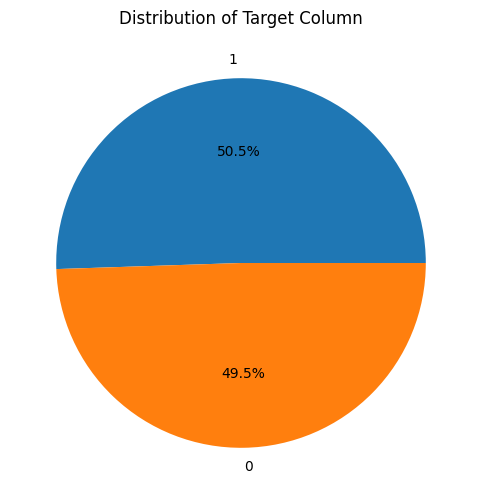

In [5]:
target_counts=df['target'].value_counts()
plt.figure(figsize=(8, 6))
plt.pie(target_counts, labels=target_counts.index, autopct="%1.1f%%")
plt.title("Distribution of Target Column")
plt.show()

**Target column has values 0 & 1.So,its binary classification.
Target column is balanced. 0 and 1 are distributed as nearly  50:50 percentage.**


In [6]:
allcol=list(df.columns)
b=[]
for a in allcol:
    if df[a].isna().sum()!=0:
        b.append(a)

In [7]:
len(b)

33

**Out of 76 columns ,43 columns dont have any null values.**

In [8]:
pd.set_option('display.max_rows', None)

nullvalues_percent=(df[b].isna().sum()/len(df))*100
print(nullvalues_percent)

RealTimeProtectionState               0.066
AntivirusConfigID                     0.076
NumAntivirusProductsInstalled         0.076
NumAntivirusProductsEnabled           0.076
CityID                                0.623
IsSystemProtected                     0.076
SMode                                 0.981
IEVersionID                           0.107
FirewallEnabled                       0.166
EnableLUA                             0.019
OEMNameID                             0.212
OEMModelID                            0.228
ProcessorCoreCount                    0.085
ProcessorManufacturerID               0.085
ProcessorModelID                      0.085
PrimaryDiskCapacityMB                 0.110
PrimaryDiskType                       0.023
SystemVolumeCapacityMB                0.110
TotalPhysicalRAMMB                    0.151
ChassisType                           0.002
PrimaryDisplayDiagonalInches          0.072
PrimaryDisplayResolutionHorizontal    0.072
PrimaryDisplayResolutionVertical

**we can see in above 33 columns,there is  very much less percentage of null values.So,all columns are important.**

In [9]:
pd.set_option('display.max_columns', None) 
print(df.describe())


       IsBetaUser  RealTimeProtectionState  IsPassiveModeEnabled  \
count    100000.0             99934.000000         100000.000000   
mean          0.0                 6.848430              0.017620   
std           0.0                 1.015166              0.131566   
min           0.0                 0.000000              0.000000   
25%           0.0                 7.000000              0.000000   
50%           0.0                 7.000000              0.000000   
75%           0.0                 7.000000              0.000000   
max           0.0                 8.000000              1.000000   

       AntivirusConfigID  NumAntivirusProductsInstalled  \
count       99924.000000                   99924.000000   
mean        47975.710440                       1.326528   
std         13803.321533                       0.520681   
min            39.000000                       1.000000   
25%         49480.000000                       1.000000   
50%         53447.000000         

* 'IsFlightsDisabled','AutoSampleSubmissionEnabled','IsBetaUser'' has all values 0 .Because minimum value and maximum value is 0.
* RealTimeProtectionState' has most values 7 in it.Because 25th,50th and 75th percentile is 7.
*   Similarly,'IsPassiveModeEnabled','SMode','HasOpticalDiskDrive','IsPortableOS',IsVirtualDevice','IsTouchEnabled','IsPenCapable','IsAlwaysOnAlwaysConnectedCapable' has most values 0. * Has tpm','IsSystemProtected','FirewallEnabled'most values are 1.


In [10]:
pd.set_option('display.max_columns', None)
df.describe(include=['object'])


,MachineID,ProductName,EngineVersion,AppVersion,SignatureVersion,PlatformType,Processor,OSVersion,OsPlatformSubRelease,OSBuildLab,SKUEditionName,MDC2FormFactor,DeviceFamily,PrimaryDiskType,ChassisType,PowerPlatformRole,NumericOSVersion,OSArchitecture,OSBranch,OSEdition,OSSkuFriendlyName,OSInstallType,AutoUpdateOptionsName,OSGenuineState,LicenseActivationChannel,FlightRing,DateAS,DateOS
count,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,99977,99998,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,100000,99976
unique,99835,2,37,69,2735,4,3,7,9,281,8,11,2,4,28,9,221,3,13,20,18,9,6,4,6,7,2695,112
top,8e0523438a5ca48323f50b2c47f6d31a,win8defender,1.1.15200.1,4.18.1807.18075,1.273.1420.0,windows10,x64,10.0.0.0,rs4,17134.1.amd64fre.rs4_release.180410-1804,Home,Notebook,Windows.Desktop,HDD,Notebook,Mobile,10.0.17134.228,amd64,rs4_release,Core,CORE,UUPUpgrade,FullAuto,IS_GENUINE,Retail,Retail,2018-08-15 06:29:00,2018-08-14
freq,2,99771,45219,62119,1274,98344,91262,98368,45837,42964,62863,64547,99971,66202,59459,69874,17069,91281,46909,39275,39273,32033,45154,89860,52195,94153,1274,20905


 
 * **MachineIDs are unique for all because  99835 are  unique values out of 100000 total.The most frequent MachineID appears only twice, indicating each machine is mostly distinct.**
* **ProductName has only 2 unique values in which 'win8defender' is dominant with frequecy of 99771There are 4 types in PlatformType.But,windows10 is highly dominant with total count of 98344OSVersion has domianance of 10.0.0.0 version.Its frequency is 98368.**
 * **In DeviceFamily columns there are total 2 types and Windows.Desktop	 is highly used with 99971 count**


In [11]:
selected_o=['PlatformType',
 'Processor',
 'OSVersion',
 'OsPlatformSubRelease',
 'SKUEditionName',
 'MDC2FormFactor',
 'PrimaryDiskType',
  'PowerPlatformRole']

In [12]:
selected_o2=['OSArchitecture',
 'OSBranch','OSInstallType',
 'AutoUpdateOptionsName',
 'OSGenuineState',
 'LicenseActivationChannel',
 'FlightRing']

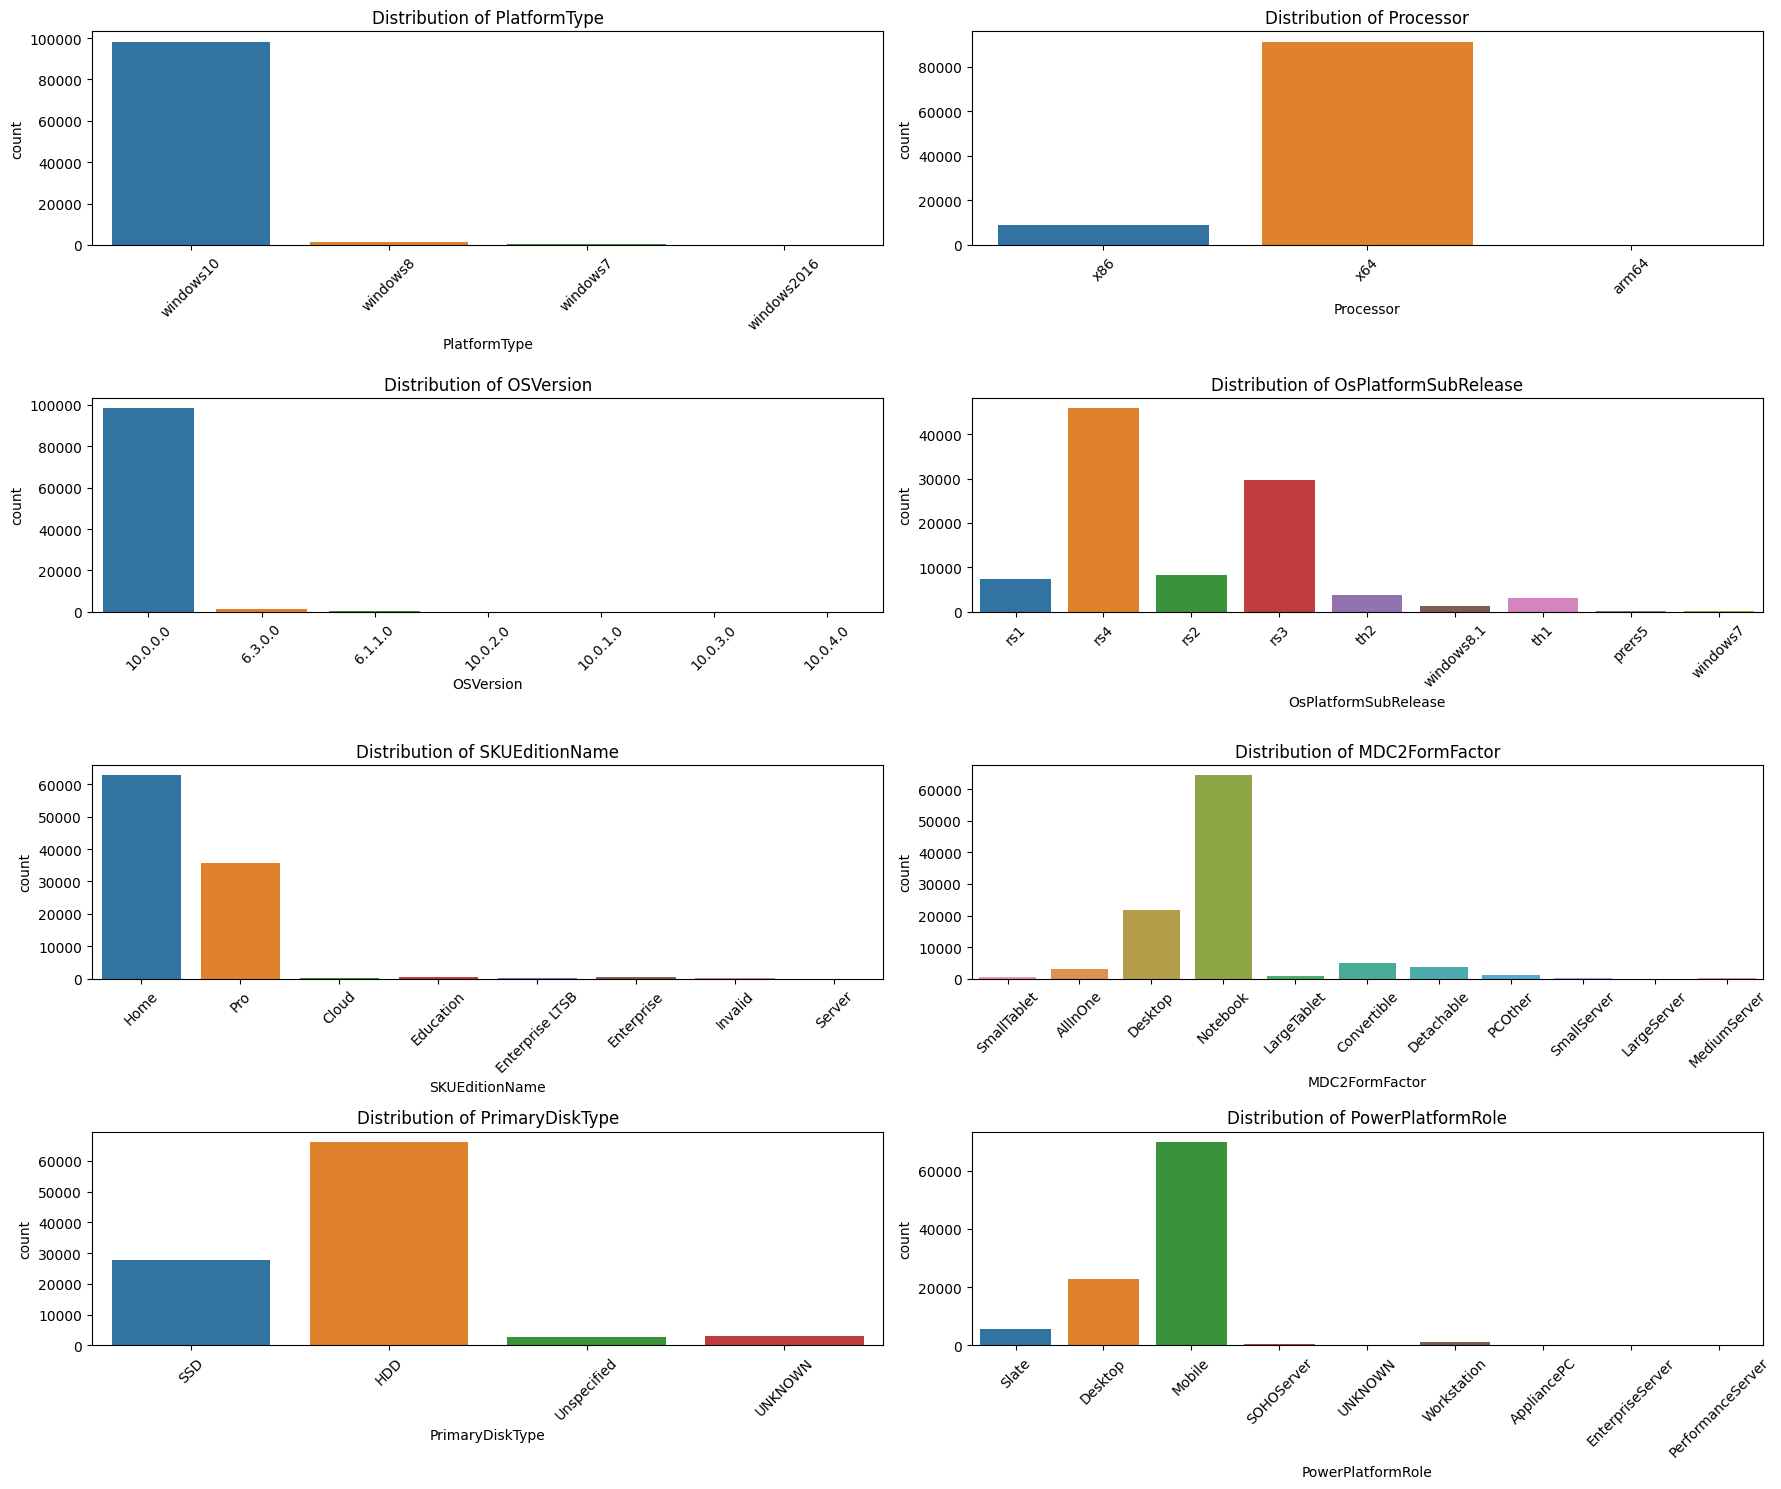

In [13]:
fig, axes = plt.subplots(4,2,figsize = (18,15))
axes  = axes.flatten()

for i,col in enumerate(selected_o) :
    sns.countplot(data = df, x = col, ax = axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation = 45)

plt.tight_layout()
plt.show()

* **From above count plots , how values in features are distributed are shown.**
* **Like in Processor , x64 is quite dominant over other 2 values.Also.in case of PrimaryDiskType HDD has higher frequecy than others.**

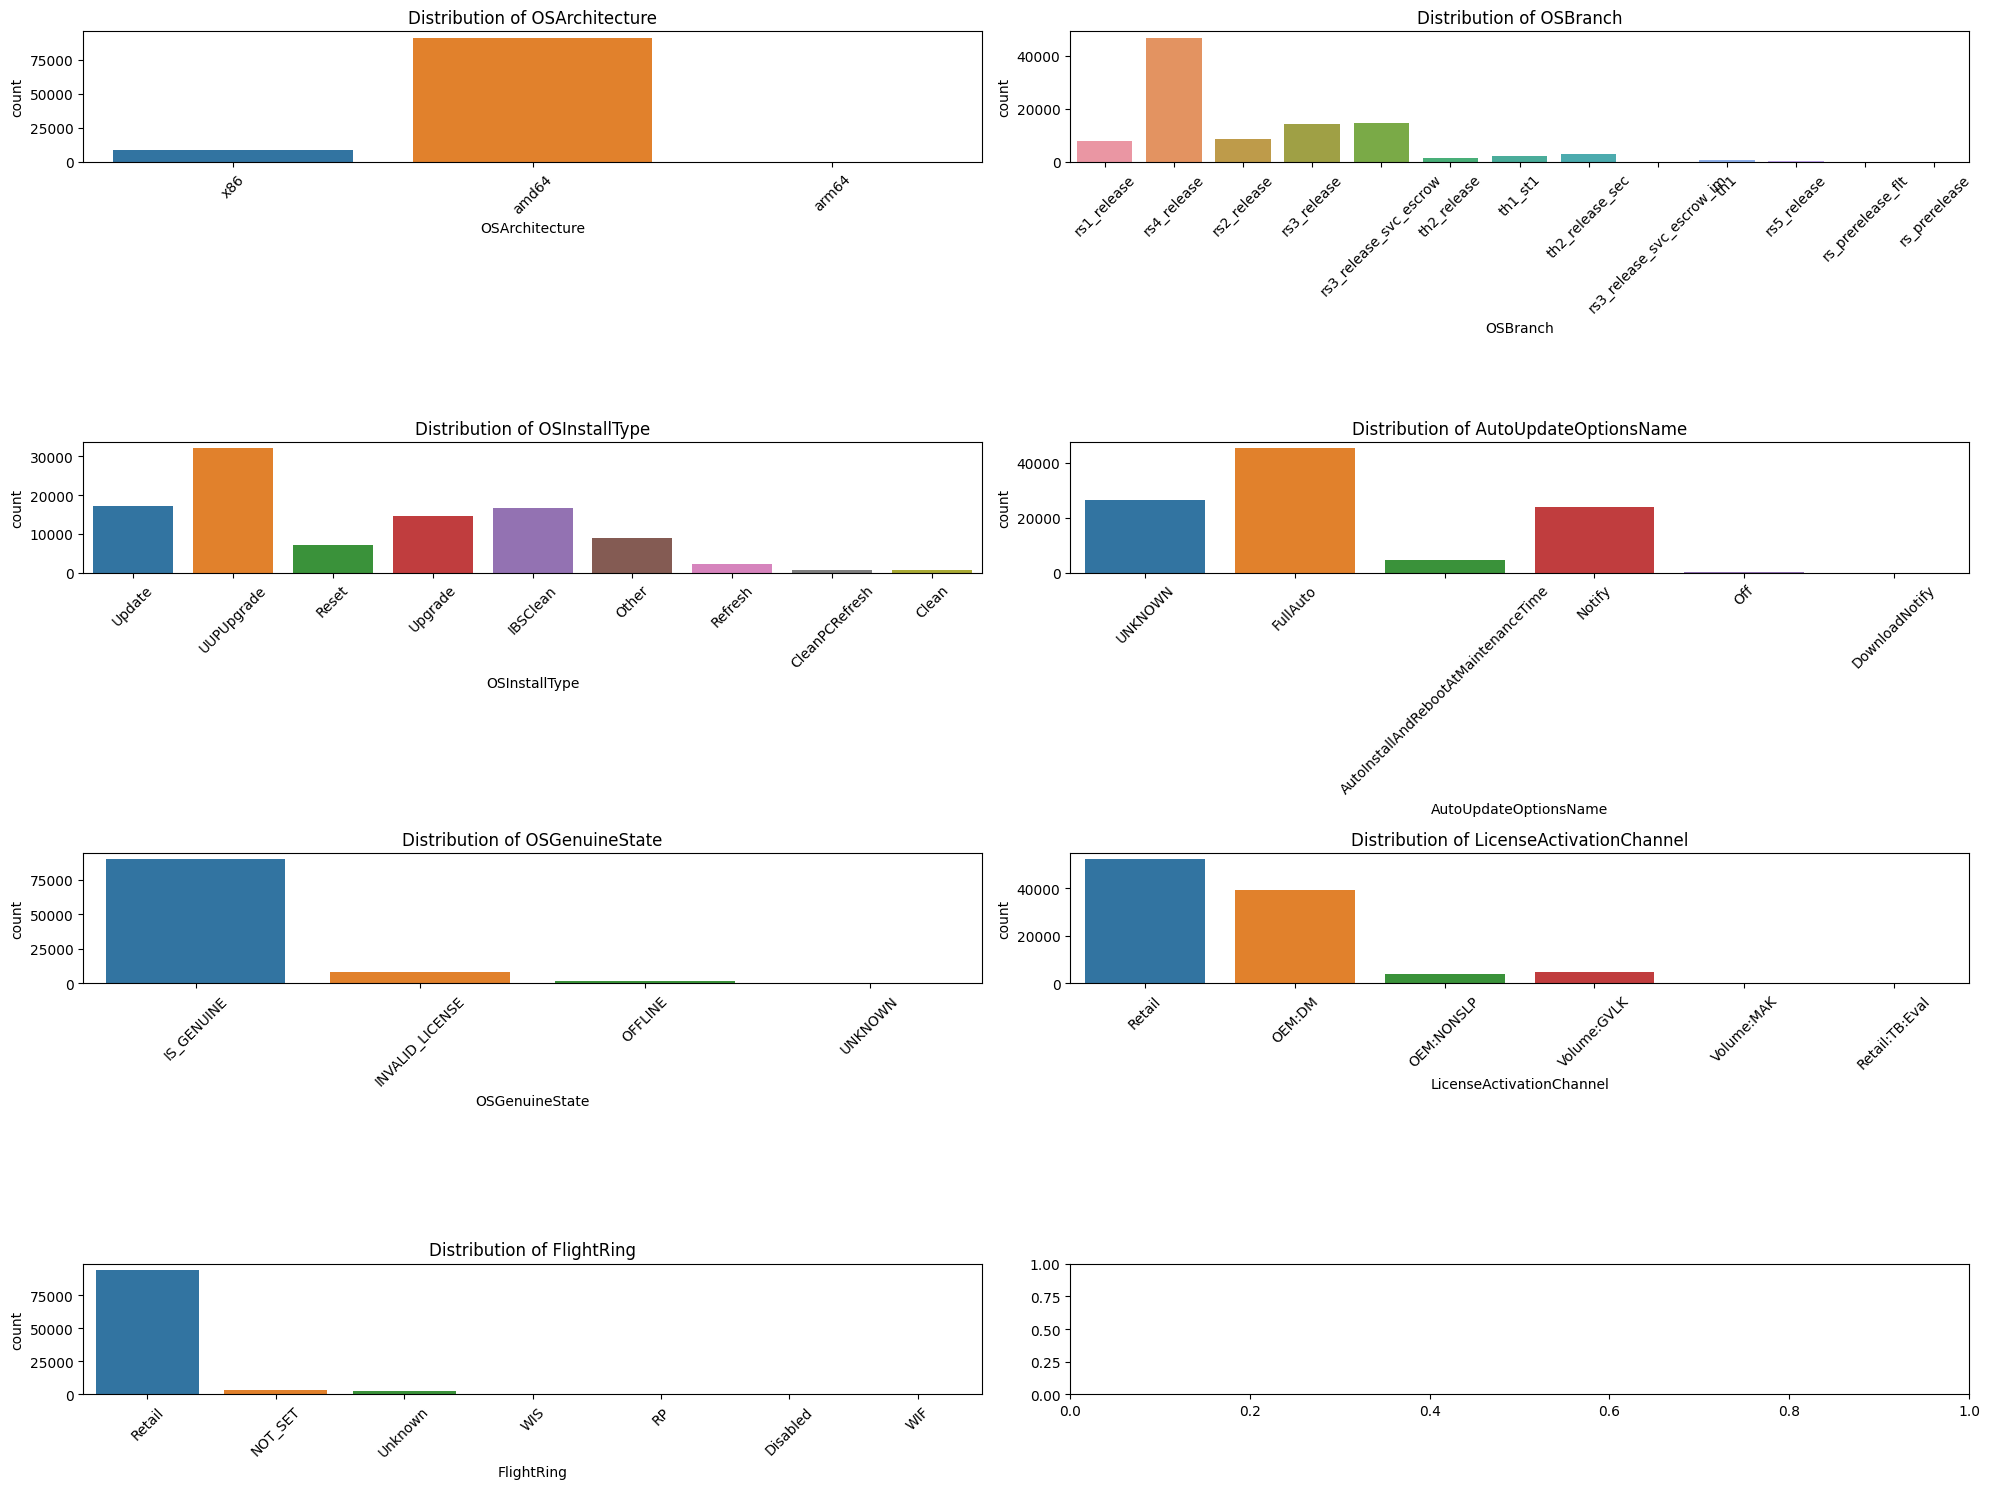

In [14]:
fig, axes = plt.subplots(4,2,figsize = (20,15))
axes  = axes.flatten()

for i,col in enumerate(selected_o2) :
    sns.countplot(data = df, x = col, ax = axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(),rotation = 45)

plt.tight_layout()
plt.show()

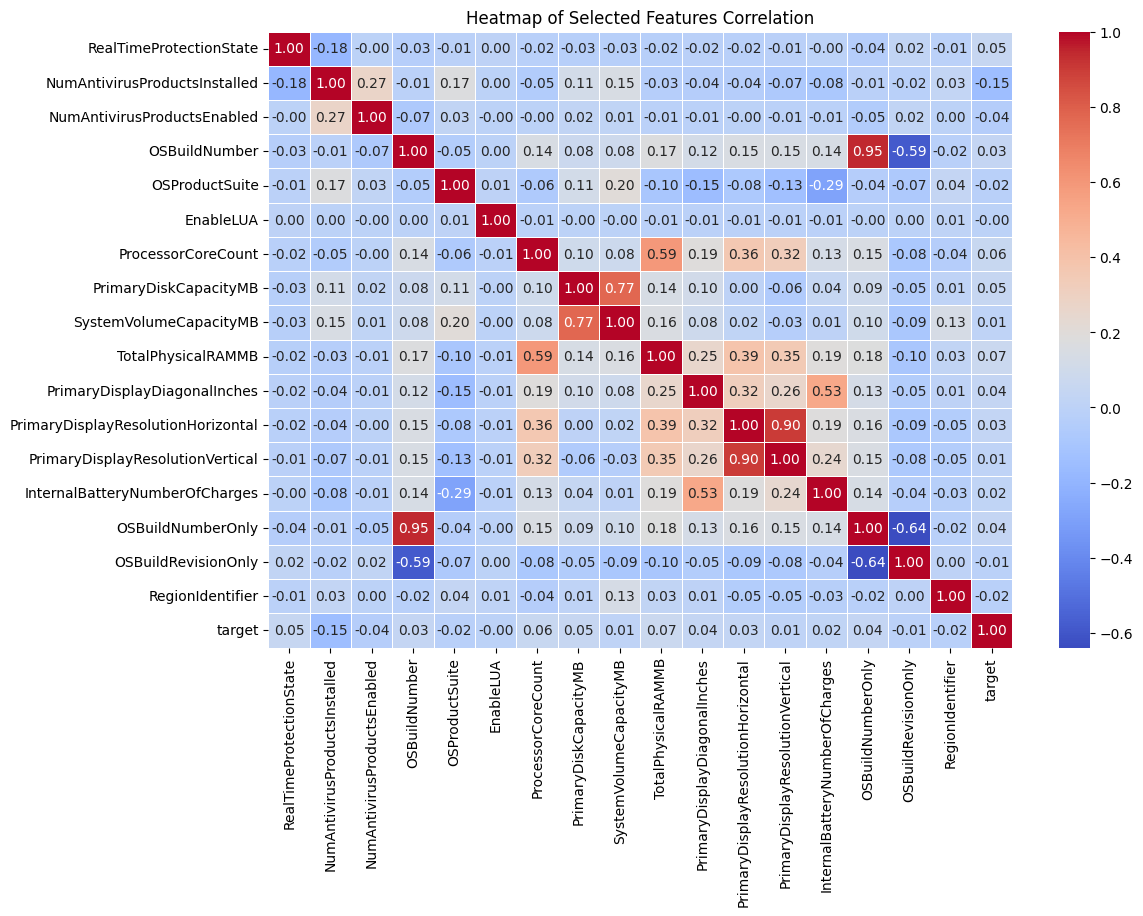

In [15]:


corr_columns = [
    'RealTimeProtectionState', 'NumAntivirusProductsInstalled', 'NumAntivirusProductsEnabled', 
    'OSBuildNumber', 'OSProductSuite', 'EnableLUA', 'ProcessorCoreCount', 'PrimaryDiskCapacityMB', 
    'SystemVolumeCapacityMB', 'TotalPhysicalRAMMB', 'PrimaryDisplayDiagonalInches', 
    'PrimaryDisplayResolutionHorizontal', 'PrimaryDisplayResolutionVertical', 
    'InternalBatteryNumberOfCharges', 'OSBuildNumberOnly', 'OSBuildRevisionOnly', 
    'RegionIdentifier', 'target'
]

df_corr = df[corr_columns]

corr_matrix = df_corr.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Selected Features Correlation")
plt.show()


* **Above is heatmap of numerical features.We can see from heatmap that how features are correlated with each other and how they are related with target. OSBuildNumberOnly and OSBuildNumber are highly correlated with each other.They have correlation of 0.95.So,one of them could be dropped.OSBuildNumberOnly  will be dropped.**
* **Other features have moderate or low correlation with each other.**
* **Also,all features have low or moderate correlation with target.**


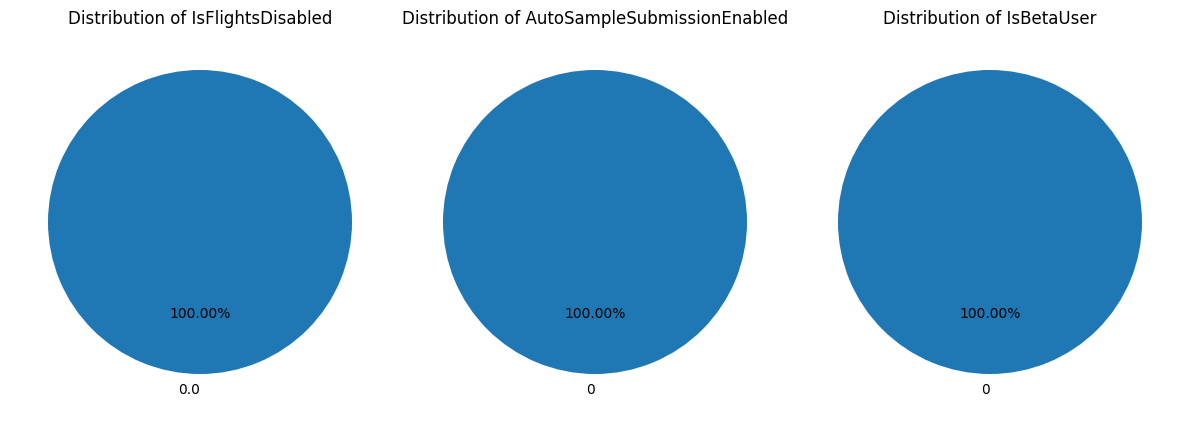

In [16]:
col3=['IsFlightsDisabled','AutoSampleSubmissionEnabled','IsBetaUser']
fig, axes = plt.subplots(1, 3, figsize=(12,10))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e']

for i, col in enumerate(col3):
    value_counts = df[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=90, colors=colors[:len(value_counts)])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

**'IsFlightsDisabled','AutoSampleSubmissionEnabled','IsBetaUser' all these 3 features have only 1 value 0 in it.So,there is no variation in column.So,these 3 are dropped.**

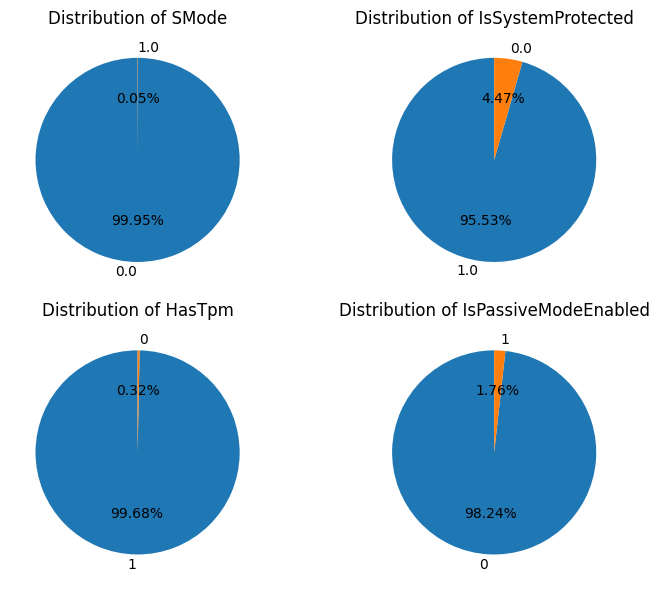

In [17]:
col2=['SMode','IsSystemProtected','HasTpm','IsPassiveModeEnabled' ]
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 2, figsize=(8,6))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e']

for i, col in enumerate(col2):
    value_counts = df[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=90, colors=colors[:len(value_counts)])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

* **In the above features,out of  values  1 & 0 ,'SMode' and 'IsPassiveModeEnabled' has dominance of value 0 where as 'IsSystemProtected' and 'HasTpm' has dominance of value 1.**
* **In above features ,only 1 value is contributing for more than 95%.**
* **So,these features can be dropped as they are showing extremely less variance**

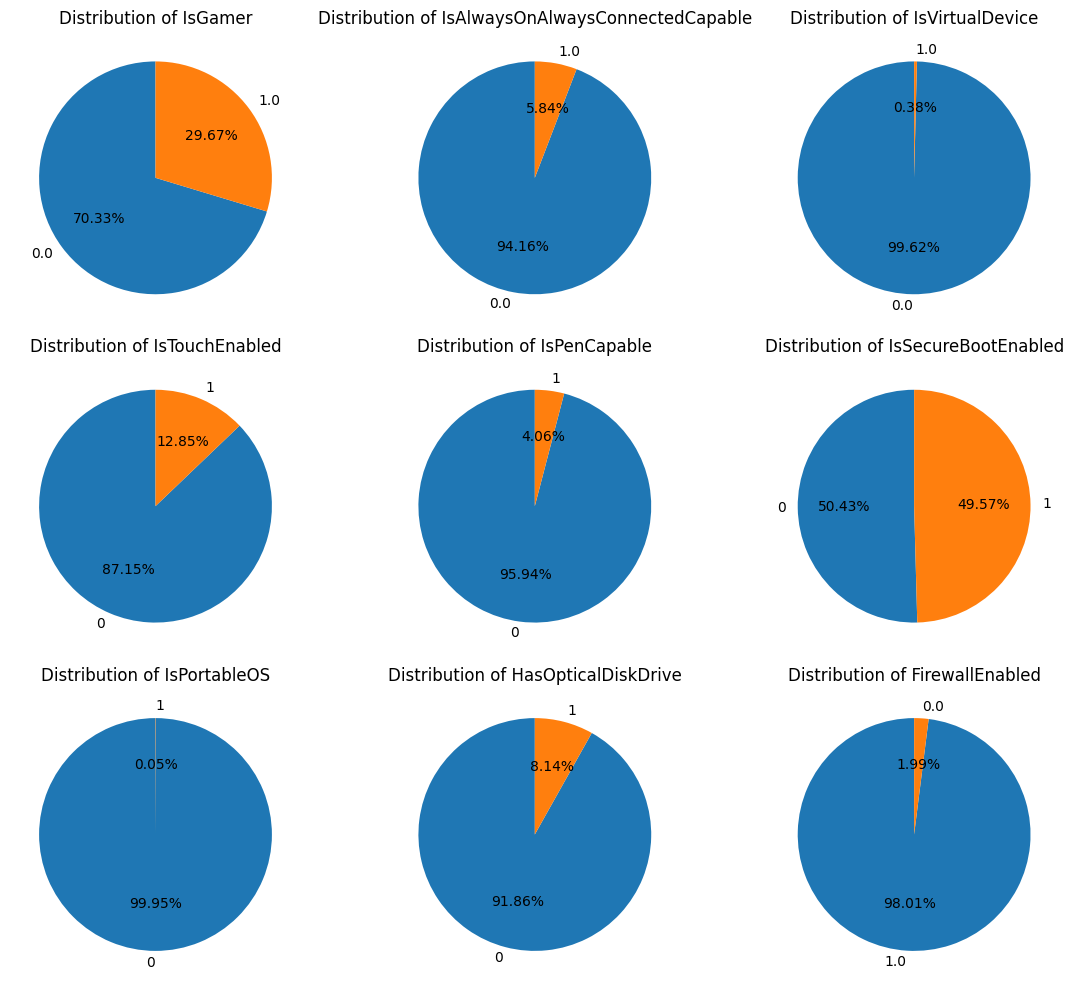

In [18]:
col=['IsGamer','IsAlwaysOnAlwaysConnectedCapable','IsVirtualDevice','IsTouchEnabled','IsPenCapable','IsSecureBootEnabled','IsPortableOS','HasOpticalDiskDrive','FirewallEnabled']
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 3, figsize=(12,10))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e']

for i, col in enumerate(col):
    value_counts = df[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=90, colors=colors[:len(value_counts)])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


**'IsSecureBootEnabled' has nearly 50:50 % distribution for values 0 & 1 
 In features- FirewallEnabled,IsPortableOS,IsPenCapable,IsVirtualDevice has dominance of one value over other which is resulting in less variability.Hence,these features can be dropped**


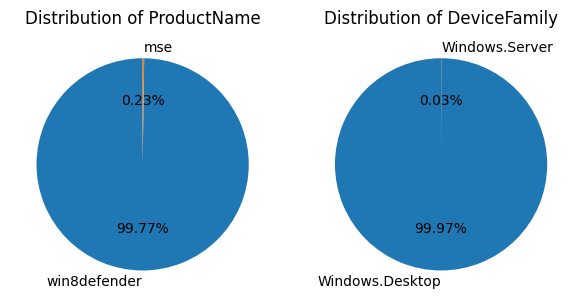

In [19]:
col4=['ProductName','DeviceFamily']
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(6,4))
axes = axes.flatten()

colors = ['#1f77b4', '#ff7f0e']

for i, col in enumerate(col4):
    value_counts = df[col].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.2f%%', startangle=90, colors=colors[:len(value_counts)])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()



 **Categorical features ProductName and DeviceFamily both have extremely high dominance of win6defender and Windows.Desktop .So,these features are dropped.**

## Data Preprocessing

In [20]:
ac=list(df.columns)

In [21]:
a=[]
for i in ac:
    if 'ID' in i:
        a.append(i)
a

['MachineID',
 'AntivirusConfigID',
 'CountryID',
 'CityID',
 'GeoRegionID',
 'LocaleEnglishNameID',
 'IEVersionID',
 'OEMNameID',
 'OEMModelID',
 'ProcessorManufacturerID',
 'ProcessorModelID',
 'OSInstallLanguageID',
 'OSUILocaleID',
 'FirmwareManufacturerID',
 'FirmwareVersionID']

Above are all ID columns in data which can be dropped.Because they are unique for data points and they have no effect on result.

DateOS and DateAS are also dropped.

In [22]:
x=df.drop(columns=['MachineID',
 'AntivirusConfigID',
 'CountryID',
 'CityID',
 'GeoRegionID',
 'LocaleEnglishNameID',
 'IEVersionID',
 'OEMNameID',
 'OEMModelID',
 'ProcessorManufacturerID',
 'ProcessorModelID',
 'OSInstallLanguageID',
 'OSUILocaleID',
 'FirmwareManufacturerID',
 'FirmwareVersionID'
,'IsFlightsDisabled','AutoSampleSubmissionEnabled','IsBetaUser','SMode','IsSystemProtected','HasTpm','IsPassiveModeEnabled','IsGamer','IsAlwaysOnAlwaysConnectedCapable','IsVirtualDevice','IsTouchEnabled','IsPenCapable','IsSecureBootEnabled','IsPortableOS','HasOpticalDiskDrive','FirewallEnabled','DateAS','DateOS','ProductName','DeviceFamily','OSBuildNumberOnly','target'])

In [23]:
xtest=xtest.drop(columns=['MachineID',
 'AntivirusConfigID',
 'CountryID',
 'CityID',
 'GeoRegionID',
 'LocaleEnglishNameID',
 'IEVersionID',
 'OEMNameID',
 'OEMModelID',
 'ProcessorManufacturerID',
 'ProcessorModelID',
 'OSInstallLanguageID',
 'OSUILocaleID',
 'FirmwareManufacturerID',
 'FirmwareVersionID'
 ,'IsFlightsDisabled','AutoSampleSubmissionEnabled','IsBetaUser','SMode','IsSystemProtected','HasTpm','IsPassiveModeEnabled','IsGamer','IsAlwaysOnAlwaysConnectedCapable','IsVirtualDevice','IsTouchEnabled','IsPenCapable','IsSecureBootEnabled','IsPortableOS','HasOpticalDiskDrive','FirewallEnabled','DateAS','DateOS','ProductName','OSBuildNumberOnly','DeviceFamily'])

In [24]:
x.shape

(100000, 39)

In [25]:
y=df['target']

In [26]:
objcol= x.select_dtypes(include=['object']).columns.tolist()


In [27]:
objcol

['EngineVersion',
 'AppVersion',
 'SignatureVersion',
 'PlatformType',
 'Processor',
 'OSVersion',
 'OsPlatformSubRelease',
 'OSBuildLab',
 'SKUEditionName',
 'MDC2FormFactor',
 'PrimaryDiskType',
 'ChassisType',
 'PowerPlatformRole',
 'NumericOSVersion',
 'OSArchitecture',
 'OSBranch',
 'OSEdition',
 'OSSkuFriendlyName',
 'OSInstallType',
 'AutoUpdateOptionsName',
 'OSGenuineState',
 'LicenseActivationChannel',
 'FlightRing']

In [28]:
ohepipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder',OneHotEncoder(handle_unknown='ignore')
)])

In [29]:
numcol = x.select_dtypes(include=['number']).columns.tolist()


In [30]:
numcol

['RealTimeProtectionState',
 'NumAntivirusProductsInstalled',
 'NumAntivirusProductsEnabled',
 'OSBuildNumber',
 'OSProductSuite',
 'EnableLUA',
 'ProcessorCoreCount',
 'PrimaryDiskCapacityMB',
 'SystemVolumeCapacityMB',
 'TotalPhysicalRAMMB',
 'PrimaryDisplayDiagonalInches',
 'PrimaryDisplayResolutionHorizontal',
 'PrimaryDisplayResolutionVertical',
 'InternalBatteryNumberOfCharges',
 'OSBuildRevisionOnly',
 'RegionIdentifier']

In [31]:
sspipe=Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())])

In [32]:
preprocessor=ColumnTransformer([('ohe1',ohepipeline,objcol),('sspipe5',sspipe,numcol)])

In [33]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [34]:
pipeline1 = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=10000))
])

pipeline1.fit(x_train,y_train)
y_pred1=pipeline1.predict(x_test)

accuracy1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {accuracy1:.4f}")


Accuracy: 0.6077


Accuracy: 0.6077


In [35]:
pipeline2 = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier2", xgb.XGBClassifier())
])

pipeline2.fit(x_train,y_train)
y_pred2=pipeline2.predict(x_test)

accuracy2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {accuracy2:.4f}")

Accuracy: 0.6171


Accuracy: 0.6171


In [36]:
pipeline3 = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier3", RandomForestClassifier(n_estimators=200,max_depth=30,max_features='sqrt',n_jobs=-1,warm_start=True))
])

pipeline3.fit(x_train,y_train)
y_pred3=pipeline3.predict(x_test)

accuracy3 = accuracy_score(y_test, y_pred3)
print(f"Accuracy: {accuracy3:.4f}")

Accuracy: 0.6116


 Accuracy: 0.6093


 ## Feature Engineering

## Feature Selection

In [37]:
x_train_transformed=preprocessor.fit_transform(x_train)
x_test_transformed=preprocessor.transform(x_test)

In [38]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier

estimator = XGBClassifier()
selector3 = SelectFromModel(estimator,max_features=500)

X_selectfrommodel_train = selector3.fit_transform(x_train_transformed,y_train)
X_selectfrommodel_test = selector3.transform(x_test_transformed)


In [39]:
ml = LogisticRegression(random_state = 42, max_iter = 10000)
ml.fit(X_selectfrommodel_train, y_train)
y_predml = ml.predict(X_selectfrommodel_test)
score = accuracy_score(y_test, y_predml)
score

0.60805

Accuracy:0.60805

In [40]:
ml2=xgb.XGBClassifier()
ml2.fit(X_selectfrommodel_train, y_train)
y_predml2 = ml2.predict(X_selectfrommodel_test)
score2 = accuracy_score(y_test, y_predml2)
score2


0.6171

Accuracy:0.6171

In [41]:
ml3=RandomForestClassifier(n_estimators=200,max_depth=30,max_features='sqrt',n_jobs=-1,warm_start=True)
ml3.fit(X_selectfrommodel_train, y_train)
y_predml3 = ml3.predict(X_selectfrommodel_test)
score3 = accuracy_score(y_test, y_predml3)
score3


0.61455

Accuracy:0.61365

**When SelectFromModel was applied for feature selection and then models were fitted then in case of Logistic Regression and RandomForestClassifier accuracy was increased and in case of XGBoostClassifier it remains same.**

# Hyper-parameter tuning

In [42]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

In [43]:
params={'n_estimators':[100,300,400],'max_depth':[3,6,8],'learning_rate':[0.1,0.3,0.5]}

In [44]:
estimator1=XGBClassifier()

In [45]:
grid_search=GridSearchCV(estimator1,params,verbose=3,n_jobs=-1,cv=3)

In [46]:
grid_search.fit(X_selectfrommodel_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.5],
                         'max_depth': [3, 6, 8],
                         'n_estimators': [100, 300, 400]},
             verbose=3)

In [47]:
print(grid_search.best_params_)


{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 400}


In [48]:
ml2hpt = xgb.XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.1)
ml2hpt.fit(X_selectfrommodel_train, y_train)
y_predml2hpt = ml2hpt.predict(X_selectfrommodel_test)
score2hpt = accuracy_score(y_test, y_predml2hpt)
score2hpt


0.6184

accracy after tuning is 0.6184

**Hyper parameter tuning is done for best model which is XGBoost Classifier and then it was fitted on selected features for best results .And accuracy is increased.**

## Model Comparison

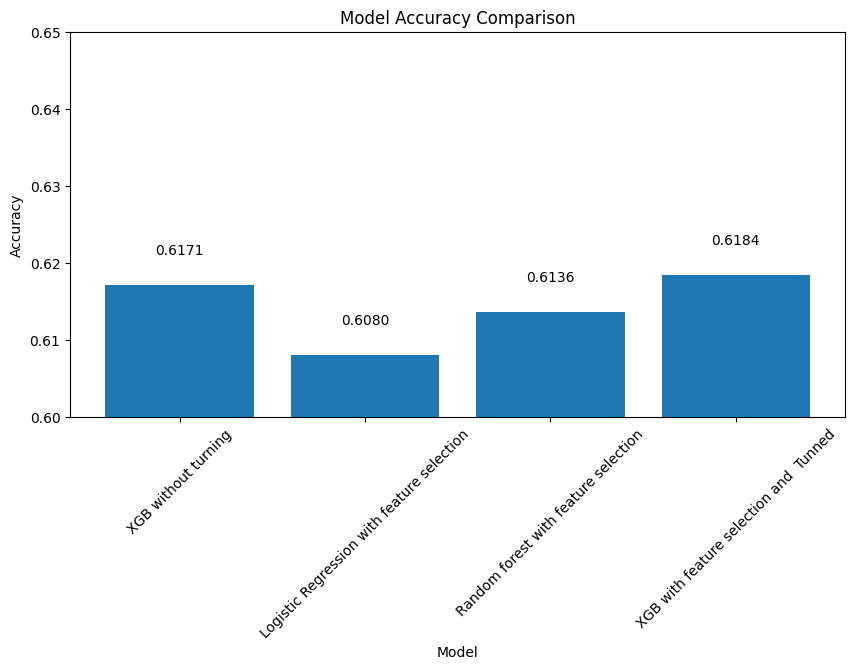

In [49]:
accuracy = [0.6171,0.6080,0.6136,0.6184]
model_name = ['XGB without turning','Logistic Regression with feature selection','Random forest with feature selection','XGB with feature selection and  Tunned']
plt.figure(figsize=(10, 5))
plt.bar(model_name, accuracy)
plt.xlabel("Model")
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.ylim(0.6, 0.65)

for i, v in enumerate(accuracy):
    plt.text(i, v + 0.004, f"{v:.4f}", ha='center', fontsize=10)
plt.show()


* **In above graph, it can be  noted that XGBoost Classifier is even performing better without tuning and selection than Logistic regression and random forest classifier which were fitted on selected features.**
* **XGBoost classifier's accuracy got increased after tuning.**

In [50]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
report = classification_report(y_test,y_predml2hpt)

print(report)

              precision    recall  f1-score   support

           0       0.62      0.58      0.60      9878
           1       0.61      0.66      0.64     10122

    accuracy                           0.62     20000
   macro avg       0.62      0.62      0.62     20000
weighted avg       0.62      0.62      0.62     20000



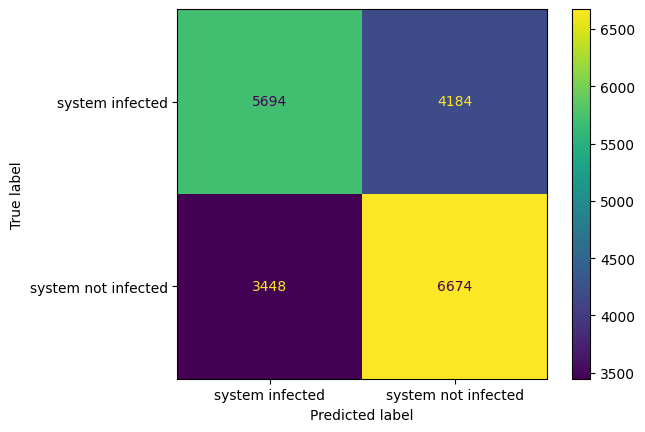

In [51]:
conf_mat = confusion_matrix(y_test,y_predml2hpt,labels=ml2hpt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=['system infected','system not infected'])
disp.plot()

## Final Model Submissision

In [52]:
train_transformed=preprocessor.fit_transform(x)
test_transformed=preprocessor.transform(xtest)

In [53]:
festimator = XGBClassifier()
fselector3 = SelectFromModel(festimator,max_features=500)

selectfrommodel_train = fselector3.fit_transform(train_transformed,y)
selectfrommodel_test = fselector3.transform(test_transformed)


In [54]:
fm = xgb.XGBClassifier(n_estimators=400, max_depth=6, learning_rate=0.1)
fm.fit(selectfrommodel_train, y)
fpred = fm.predict(selectfrommodel_test)
submission=pd.DataFrame({'id':range(0,10000),'target':fpred})
submission.to_csv('submission.csv',index=False)
 
